In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

from tqdm import trange, tqdm

from collections import defaultdict, Counter
from itertools import combinations

In [2]:
def read_snap(edge_file, com_file, prefix=""):
    edges = pd.read_csv(prefix+edge_file, sep='\t', comment="#")
    coms = []
    with open(prefix+com_file, "r") as infile:
        for line in infile:
            x = line[:-1]  # drop trailing newline
            x = x.split('\t')
            coms.append(tuple([int(y) for y in x]))

    g = ig.Graph.DataFrame(edges, directed=False)

    c = [list() for _ in range(g.vcount())]
    for i, com in enumerate(coms):
        for v in com:
            c[v].append(i)
    c = [tuple(i) for i in c] 
    g.vs["comms"] = c

    # Vertex list is not continugous, drop degree 0 vertices
    g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  

    return g, g.vs["comms"]


def read_abcdoo_coms(com_file, prefix=""):
    ## read communities
    file = prefix+com_file
    c = []
    with open(file, "r") as infile:
        for line in infile:
            x = line.split('\t')
            coms = [int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]  # map to 0-based
            try:
                coms.remove(0)  # Community 0 is outliers
            except ValueError:
                pass
            c.append(tuple(coms)) 

    return c

In [ ]:
## DBLP graph
dblp_g, dblp_coms = read_snap("com-dblp.ungraph.txt", "com-dblp.all.cmty.txt", "../../SNAP/")
abcdoo_d2_coms = read_abcdoo_coms("abcdoo_dblp_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d5_coms = read_abcdoo_coms("abcdoo_dblp_d5_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d10_coms = read_abcdoo_coms("abcdoo_dblp_d10_com.dat", "../../ABCDGraphGenerator.jl/utils/")
cbk_coms = read_abcdoo_coms("dblp_cbk.dat", "../")

print(f"DBLP: min coms is {np.min([len(c) for c in dblp_coms if len(c) > 0])} and max is {np.max([len(c) for c in dblp_coms])}")
print(f"DBLP: min coms is {np.min([len(c) for c in abcdoo_d2_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d2_coms])}")
print(f"DBLP: min coms is {np.min([len(c) for c in abcdoo_d5_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d5_coms])}")
print(f"DBLP: min coms is {np.min([len(c) for c in abcdoo_d10_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d10_coms])}")
print(f"DBLP: min coms is {np.min([len(c) for c in cbk_coms if len(c) > 0])} and max is {np.max([len(c) for c in cbk_coms])}")


DBLP: min coms is 1 and max is 124
DBLP: min coms is 1 and max is 10
DBLP: min coms is 1 and max is 9
DBLP: min coms is 1 and max is 31
DBLP: min coms is 1 and max is 124


100%|██████████| 317080/317080 [01:25<00:00, 3698.89it/s]  


Skipped 165 nodes.


100%|██████████| 317080/317080 [00:01<00:00, 241017.36it/s]


Skipped 0 nodes.


100%|██████████| 317080/317080 [00:00<00:00, 393576.82it/s]


Skipped 0 nodes.


100%|██████████| 317080/317080 [00:03<00:00, 86226.11it/s]


Skipped 0 nodes.


100%|██████████| 317080/317080 [02:26<00:00, 2157.10it/s]


Skipped 1291 nodes.


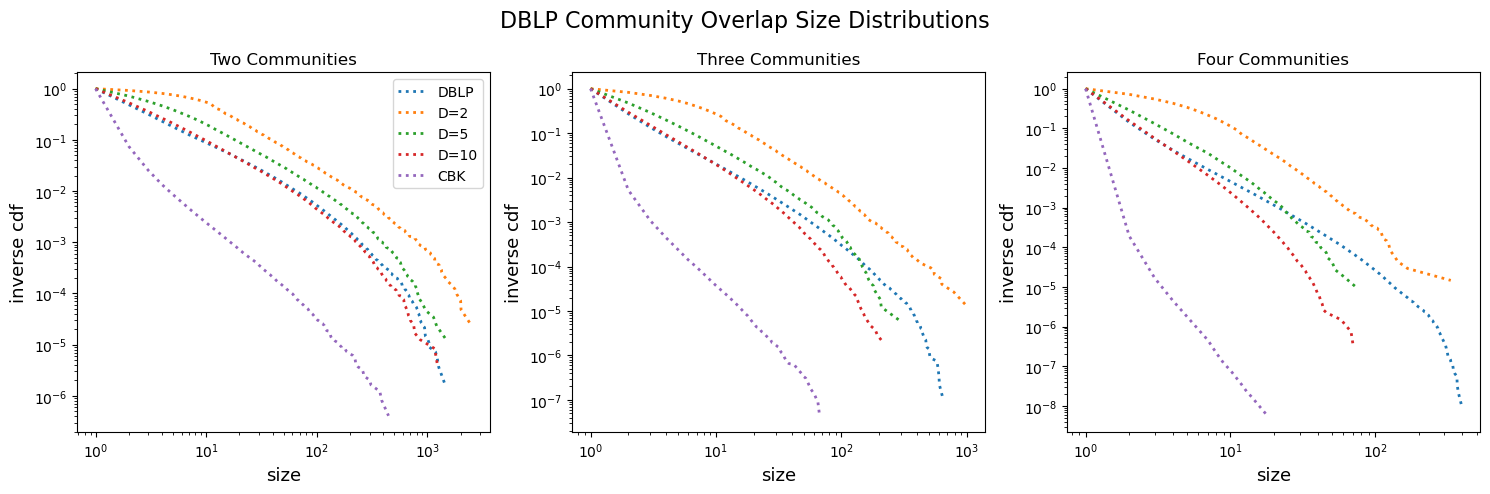

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

options = [dblp_coms, abcdoo_d2_coms, abcdoo_d5_coms, abcdoo_d10_coms, cbk_coms]
names = ["DBLP", "D=2", "D=5", "D=10", "CBK"]
for coms, name in zip(options, names):

    two_overlaps = defaultdict(int)
    three_overlaps = defaultdict(int)
    four_overlaps = defaultdict(int)
    skipped = 0
    for com in tqdm(coms):
        if len(com) > 50:
            skipped += 1
            continue
        for k2 in combinations(com, 2):
            two_overlaps[tuple(sorted(k2))] += 1
        for k3 in combinations(com, 3):
            three_overlaps[tuple(sorted(k3))] += 1
        for k4 in combinations(com, 4):
            four_overlaps[tuple(sorted(k4))] += 1
    print(f"Skipped {skipped} nodes.")

    for i, overlaps in enumerate([two_overlaps, three_overlaps, four_overlaps]):
        X = powerlaw.Fit(list(overlaps.values()), xmin=1)
        #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
        X.plot_ccdf(ax=axs[i], linewidth=2, original_data=False, linestyle=":", label=name)
        #print(name)
        #print("\ngamma:", X.power_law.alpha)
        #print("l':", X.power_law.xmin)
        #print("KS statistic:", X.power_law.D)

        
        axs[i].set_xlabel("size", fontsize=13)
        axs[i].set_ylabel("inverse cdf", fontsize=13)

axs[0].legend()
axs[0].set_title("Two Communities")
axs[1].set_title("Three Communities") 
axs[2].set_title("Four Communities") 
plt.suptitle("DBLP Community Overlap Size Distributions", fontsize=16)
plt.tight_layout()

In [6]:
## Amazon graph
amazon_g, amazon_coms = read_snap("com-amazon.ungraph.txt", "com-amazon.all.dedup.cmty.txt", "../../SNAP/")
abcdoo_d2_coms = read_abcdoo_coms("abcdoo_amazon_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d5_coms = read_abcdoo_coms("abcdoo_amazon_d5_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d10_coms = read_abcdoo_coms("abcdoo_amazon_d10_com.dat", "../../ABCDGraphGenerator.jl/utils/")
cbk_coms = read_abcdoo_coms("amazon_cbk.dat", "../")

print(f"Amazon: min coms is {np.min([len(c) for c in amazon_coms if len(c) > 0])} and max is {np.max([len(c) for c in amazon_coms])}")
print(f"Amazon: min coms is {np.min([len(c) for c in abcdoo_d2_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d2_coms])}")
print(f"Amazon: min coms is {np.min([len(c) for c in abcdoo_d5_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d5_coms])}")
print(f"Amazon: min coms is {np.min([len(c) for c in abcdoo_d10_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d10_coms])}")
print(f"Amazon: min coms is {np.min([len(c) for c in cbk_coms if len(c) > 0])} and max is {np.max([len(c) for c in cbk_coms])}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [amazon_coms, abcdoo_d2_coms, abcdoo_d5_coms, abcdoo_d10_coms, cbk_coms]
names = ["Amazon", "D=2", "D=5", "D=10", "CBK"]

options = [abcdoo_d2_coms, cbk_coms]
names = ["D2", "CBK"]
for coms, name in zip(options, names):

    two_overlaps = defaultdict(int)
    three_overlaps = defaultdict(int)
    four_overlaps = defaultdict(int)
    skipped = 0
    for com in tqdm(coms):
        if len(com) > 150:
            skipped += 1
            continue
        for k2 in combinations(com, 2):
            two_overlaps[tuple(sorted(k2))] += 1
        for k3 in combinations(com, 3):
            three_overlaps[tuple(sorted(k3))] += 1
        for k4 in combinations(com, 4):
            four_overlaps[tuple(sorted(k4))] += 1
    print(f"Skipped {skipped} nodes.")

    for i, overlaps in enumerate([two_overlaps, three_overlaps, four_overlaps]):
        X = powerlaw.Fit(list(overlaps.values()), xmin=1)
        #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
        X.plot_ccdf(ax=axs[i], linewidth=2, original_data=False, linestyle=":", label=name)
        #print(name)
        #print("\ngamma:", X.power_law.alpha)
        #print("l':", X.power_law.xmin)
        #print("KS statistic:", X.power_law.D)

        
        axs[i].set_xlabel("size", fontsize=13)
        axs[i].set_ylabel("inverse cdf", fontsize=13)

    del two_overlaps
    del three_overlaps
    del four_overlaps

axs[0].legend()
axs[0].set_title("Two Communities")
axs[1].set_title("Three Communities") 
axs[2].set_title("Four Communities") 
plt.suptitle("Amazon Community Overlap Size Distributions", fontsize=16)
plt.tight_layout()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1041b5f10>>
Traceback (most recent call last):
  File "/Users/ryandewolfe/miniforge3/envs/betastar/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Youtube: min coms is 1 and max is 227
D2: min coms is 1 and max is 7
D5: min coms is 1 and max is 8
D10: min coms is 1 and max is 21
CBK: min coms is 1 and max is 227


100%|██████████| 52675/52675 [00:54<00:00, 974.40it/s]  


Skipped 17 nodes.


100%|██████████| 52675/52675 [00:00<00:00, 148202.41it/s]


Skipped 0 nodes.


100%|██████████| 52675/52675 [00:00<00:00, 561628.14it/s]


Skipped 0 nodes.


100%|██████████| 52675/52675 [00:00<00:00, 140935.03it/s]


Skipped 0 nodes.


100%|██████████| 52675/52675 [48:47<00:00, 17.99it/s]  


Skipped 105 nodes.


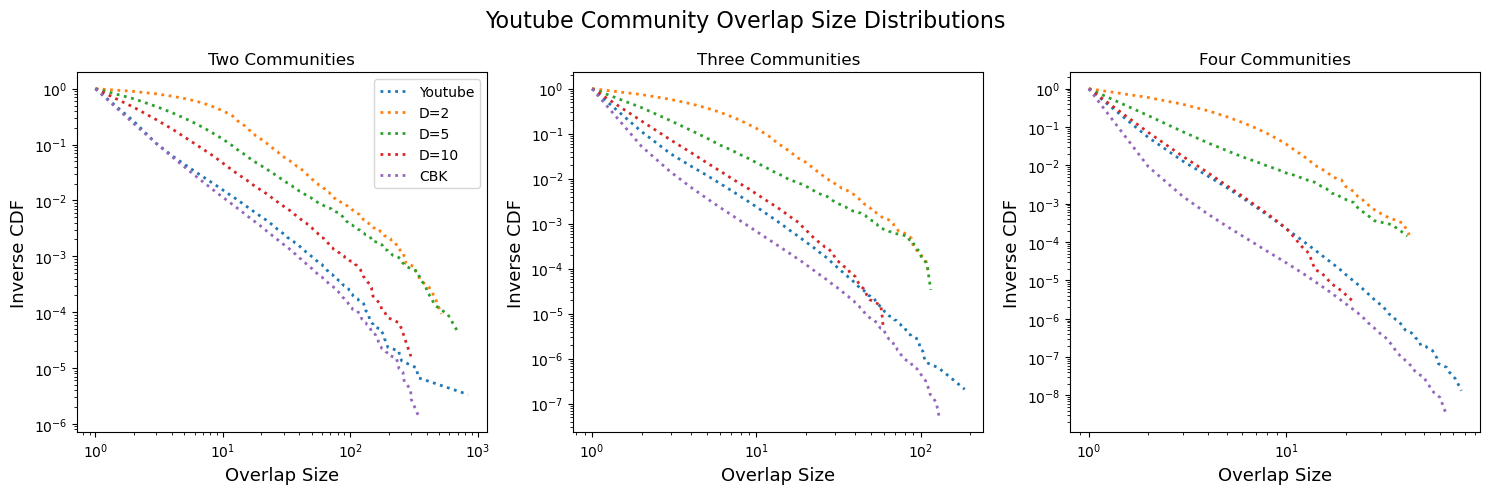

In [18]:
youtube_g, youtube_coms = read_snap("com-youtube.ungraph.txt", "com-youtube.all.cmty.txt", "../../SNAP/")
# Drop outliers
is_outlier = np.array([len(comms) == 0 for comms in youtube_g.vs["comms"]])
youtube_g = youtube_g.subgraph(np.argwhere(~is_outlier).reshape(-1))
youtube_coms = [youtube_coms[i] for i in range(len(youtube_coms)) if not is_outlier[i]]
abcdoo_d2_coms = read_abcdoo_coms("abcdoo_youtube_nooutliers_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d5_coms = read_abcdoo_coms("abcdoo_youtube_nooutliers_d5_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d10_coms = read_abcdoo_coms("abcdoo_youtube_nooutliers_d10_com.dat", "../../ABCDGraphGenerator.jl/utils/")
cbk_coms = read_abcdoo_coms("youtube_cbk.dat", "../")

print(f"Youtube: min coms is {np.min([len(c) for c in youtube_coms if len(c) > 0])} and max is {np.max([len(c) for c in youtube_coms])}")
print(f"D2: min coms is {np.min([len(c) for c in abcdoo_d2_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d2_coms])}")
print(f"D5: min coms is {np.min([len(c) for c in abcdoo_d5_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d5_coms])}")
print(f"D10: min coms is {np.min([len(c) for c in abcdoo_d10_coms if len(c) > 0])} and max is {np.max([len(c) for c in abcdoo_d10_coms])}")
print(f"CBK: min coms is {np.min([len(c) for c in cbk_coms if len(c) > 0])} and max is {np.max([len(c) for c in cbk_coms])}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [youtube_coms, abcdoo_d2_coms, abcdoo_d5_coms, abcdoo_d10_coms, cbk_coms]
names = ["Youtube", "D=2", "D=5", "D=10", "CBK"]
for coms, name in zip(options, names):

    two_overlaps = defaultdict(int)
    three_overlaps = defaultdict(int)
    four_overlaps = defaultdict(int)
    skipped = 0
    for com in tqdm(coms):
        if len(com) > 100:
            skipped += 1
            continue
        for k2 in combinations(com, 2):
            two_overlaps[tuple(sorted(k2))] += 1
        for k3 in combinations(com, 3):
            three_overlaps[tuple(sorted(k3))] += 1
        for k4 in combinations(com, 4):
            four_overlaps[tuple(sorted(k4))] += 1
    print(f"Skipped {skipped} nodes.")

    for i, overlaps in enumerate([two_overlaps, three_overlaps, four_overlaps]):
        X = powerlaw.Fit(list(overlaps.values()), xmin=1)
        #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
        X.plot_ccdf(ax=axs[i], linewidth=2, original_data=False, linestyle=":", label=name)
        #print(name)
        #print("\ngamma:", X.power_law.alpha)
        #print("l':", X.power_law.xmin)
        #print("KS statistic:", X.power_law.D)

        
        axs[i].set_xlabel("Overlap Size", fontsize=13)
        axs[i].set_ylabel("Inverse CDF", fontsize=13)

    del two_overlaps
    del three_overlaps
    del four_overlaps

axs[0].legend()
axs[0].set_title("Two Communities")
axs[1].set_title("Three Communities") 
axs[2].set_title("Four Communities") 
plt.suptitle("Youtube Community Overlap Size Distributions", fontsize=16)
plt.tight_layout()